<a href="https://colab.research.google.com/github/nipunikajain/DeepLearning1/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

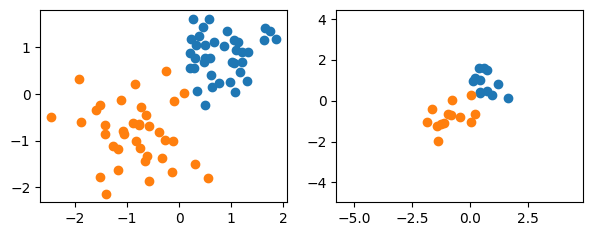

In [4]:
##########################
### DATASET
##########################

data = np.genfromtxt('toydata.txt', delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

### Low-level implementation with manual gradients

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class LogisticRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(1, num_features, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights.t()), self.bias).view(-1) # net input
        probas = self._sigmoid(linear)
        return probas
        
    def backward(self, x, y, probas):  
        grad_loss_wrt_z = probas.view(-1) - y
        grad_loss_wrt_w = torch.mm(x.t(), grad_loss_wrt_z.view(-1, 1)).t()
        grad_loss_wrt_b = torch.sum(grad_loss_wrt_z)
        return grad_loss_wrt_w, grad_loss_wrt_b
            
    def predict_labels(self, x):
        probas = self.forward(x)
        labels = torch.where(probas >= .5, 1, 0) # threshold function
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy
    
    def _sigmoid(self, z):
        return 1. / (1. + torch.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(-y.view(1, -1), torch.log(proba.view(-1, 1)))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):
            
            #### Compute outputs ####
            probas = self.forward(x)
            
            #### Compute gradients ####
            grad_w, grad_b = self.backward(x, y, probas)

            #### Update weights ####
            self.weights -= learning_rate * grad_w
            self.bias -= learning_rate * grad_b
            
            #### Logging ####
            cost = self._logit_cost(y, self.forward(x)) / x.size(0)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

model1 = LogisticRegression1(num_features=2)
epoch_cost = model1.train(X_train_tensor, y_train_tensor, num_epochs=30, learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % model1.weights)
print('  Bias: %s' % model1.bias)

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.053
Epoch: 003 | Train ACC: 0.973 | Cost: 0.051
Epoch: 004 | Train ACC: 0.973 | Cost: 0.049
Epoch: 005 | Train ACC: 0.973 | Cost: 0.048
Epoch: 006 | Train ACC: 0.973 | Cost: 0.047
Epoch: 007 | Train ACC: 0.973 | Cost: 0.046
Epoch: 008 | Train ACC: 0.973 | Cost: 0.045
Epoch: 009 | Train ACC: 0.973 | Cost: 0.044
Epoch: 010 | Train ACC: 0.987 | Cost: 0.043
Epoch: 011 | Train ACC: 0.987 | Cost: 0.042
Epoch: 012 | Train ACC: 0.987 | Cost: 0.041
Epoch: 013 | Train ACC: 0.987 | Cost: 0.041
Epoch: 014 | Train ACC: 0.987 | Cost: 0.040
Epoch: 015 | Train ACC: 0.987 | Cost: 0.039
Epoch: 016 | Train ACC: 0.987 | Cost: 0.039
Epoch: 017 | Train ACC: 1.000 | Cost: 0.038
Epoch: 018 | Train ACC: 1.000 | Cost: 0.038
Epoch: 019 | Train ACC: 1.000 | Cost: 0.037
Epoch: 020 | Train ACC: 1.000 | Cost: 0.036
Epoch: 021 | Train ACC: 1.000 | Cost: 0.036
Epoch: 022 | Train ACC: 1.000 | Cost: 0.036
Epoch: 023 | Train ACC: 1.000 | 

### Evaluating the Model

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


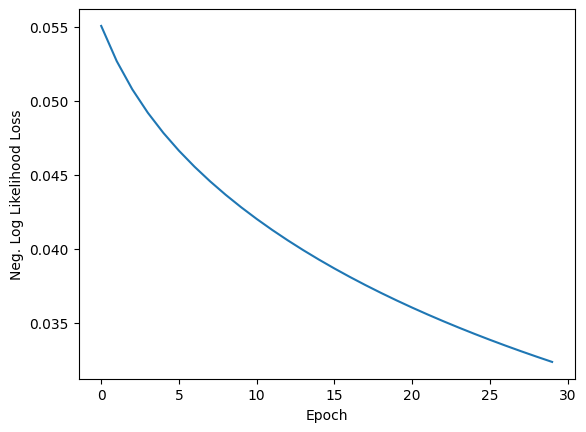

In [7]:
plt.plot(epoch_cost)
plt.ylabel('Neg. Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

In [8]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = model1.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.00%


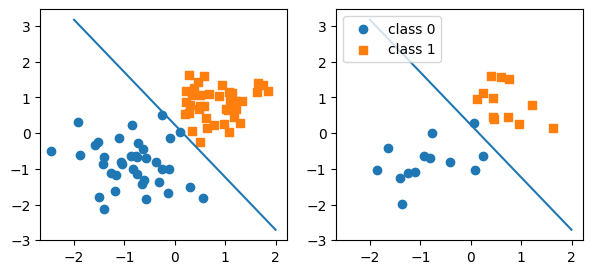

In [9]:
##########################
### 2D Decision Boundary
##########################

w, b = model1.weights.view(-1), model1.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

### High-level implementation using the nn.Module API



In [10]:
class LogisticRegression2(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

model2 = LogisticRegression2(num_features=2).to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [11]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = torch.where((pred_probas > 0.5), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc


num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model2(X_train_tensor)
    
    #### Compute gradients ####
    loss = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    loss.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model2(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.053
Epoch: 003 | Train ACC: 0.973 | Cost: 0.051
Epoch: 004 | Train ACC: 0.973 | Cost: 0.049
Epoch: 005 | Train ACC: 0.973 | Cost: 0.048
Epoch: 006 | Train ACC: 0.973 | Cost: 0.047
Epoch: 007 | Train ACC: 0.973 | Cost: 0.046
Epoch: 008 | Train ACC: 0.973 | Cost: 0.045
Epoch: 009 | Train ACC: 0.973 | Cost: 0.044
Epoch: 010 | Train ACC: 0.987 | Cost: 0.043
Epoch: 011 | Train ACC: 0.987 | Cost: 0.042
Epoch: 012 | Train ACC: 0.987 | Cost: 0.041
Epoch: 013 | Train ACC: 0.987 | Cost: 0.041
Epoch: 014 | Train ACC: 0.987 | Cost: 0.040
Epoch: 015 | Train ACC: 0.987 | Cost: 0.039
Epoch: 016 | Train ACC: 0.987 | Cost: 0.039
Epoch: 017 | Train ACC: 1.000 | Cost: 0.038
Epoch: 018 | Train ACC: 1.000 | Cost: 0.038
Epoch: 019 | Train ACC: 1.000 | Cost: 0.037
Epoch: 020 | Train ACC: 1.000 | Cost: 0.036
Epoch: 021 | Train ACC: 1.000 | Cost: 0.036
Epoch: 022 | Train ACC: 1.000 | Cost: 0.036
Epoch: 023 | Train ACC: 1.000 | 

In [12]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model2(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.00%


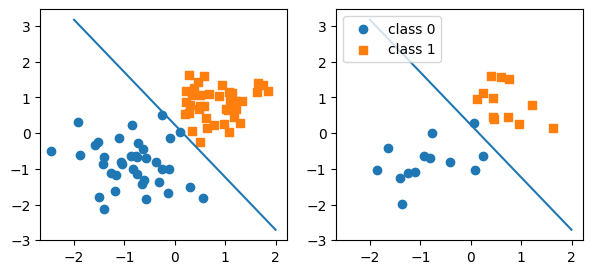

In [13]:
##########################
### 2D Decision Boundary
##########################

w, b = model2.linear.weight.detach().view(-1), model2.linear.bias.detach()

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()